In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

In [2]:
boston = spark.read.csv('csv/boston.csv', header=True, inferSchema=True)
boston.printSchema()
boston.show(5)
boston2 = boston.toPandas()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.8

### ex) 보스톤 집값 예측
* 보스턴 외곽지역 집값과 그것들과 관련있는 여러 요소를 변수로 정의
    -  범죄율, 단위면적당 거주주민수,
    -  비상업지구 거주민, 강근처 주택여부, 오염도 비율,
    -  공실비율, 노후주택 비율, 도로 접근성비율,
    -  재산세 납부비율, 학생/교사 비율, 유색인종 비율,
    -  하위계층 비율, 본인소유 주택가격

*  최종적으로 집값에 영향을 주는 요인은?

In [3]:
# 평균 주택가격 분포 확인
boston2.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
# 회귀/상관 분석
covVal = boston.cov('rm','medv')
covVal

4.4934458795444785

In [5]:
corrVal = boston.corr('rm','medv')
corrVal

0.6953599470715401

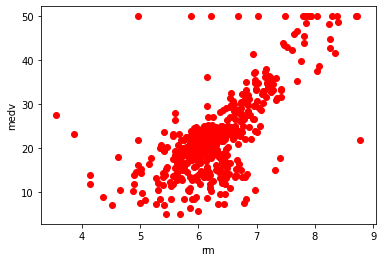

In [6]:
plt.plot(boston2['rm'],boston2['medv'],'ro')
plt.xlabel('rm')
plt.ylabel('medv')
plt.show()

In [7]:
# 상관계수 행렬 - 텍스트로 출력
boston2.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


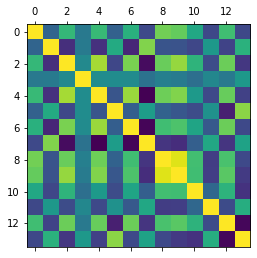

In [8]:
# 히트맵을 이용한 상관계수 시각화 1
corrdf = boston2.corr()
plt.matshow(corrdf)

<AxesSubplot:>

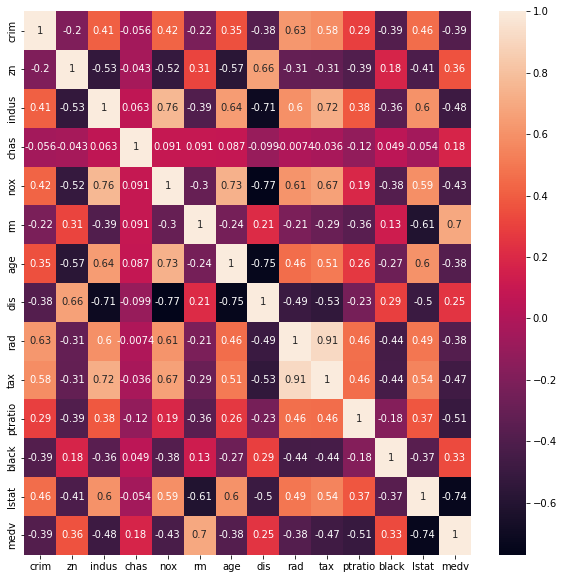

In [9]:
# 히트맵을 이용한 상관계수 2 - seaborn
plt.figure(figsize=(10,10))
sns.heatmap(corrdf, annot=True)

In [10]:
# 전처리 - 독립변수 벡터화
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat'], outputCol='features')

In [11]:
boston = va.transform(boston)

# 벡터화한 컬럼 확인
boston.select('features').show(5, False)

+-------------------------------------------------------------------------+
|features                                                                 |
+-------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]  |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14] |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]|
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]|
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33] |
+-------------------------------------------------------------------------+
only showing top 5 rows



21/11/06 09:41:44 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [12]:
# 독립변수와 종속변수를 추출해서 새로운 변수를 생성
model_df = boston.select('features','medv')
model_df = model_df.withColumnRenamed('medv','label')
model_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.02731,0.0,7.07...| 21.6|
|[0.02729,0.0,7.07...| 34.7|
|[0.03237,0.0,2.18...| 33.4|
|[0.06905,0.0,2.18...| 36.2|
+--------------------+-----+
only showing top 5 rows



In [13]:
# 훈련셋, 테스트셋 생성
seed = 2110120945
train, test = model_df.randomSplit([0.75,0.25],seed)

In [14]:
print(f'train set size : {train.count()}')
print(f'test set size : {test.count()}')

train set size : 376
test set size : 130


### 선형회귀분석
- ML 중요지표 : $R^2$, 오차값
- 통계 중요지표 : $R^2$, F통계/회귀계수, 유의확률

In [15]:
from pyspark.ml.regression import LinearRegression

In [16]:
lr = LinearRegression()
trained = lr.fit(train)
pred = trained.transform(test)
pred.select('label','prediction').show(5)

21/11/06 09:41:45 WARN Instrumentation: [59b5b256] regParam is zero, which might cause numerical instability and overfitting.
21/11/06 09:41:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/06 09:41:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/11/06 09:41:45 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/11/06 09:41:45 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+-----+------------------+
|label|        prediction|
+-----+------------------+
| 30.1| 25.12998317867188|
| 33.0| 22.53942393820208|
| 26.6| 21.40474994161692|
| 18.5| 18.95089817175425|
| 19.5|20.038435263360817|
+-----+------------------+
only showing top 5 rows



In [17]:
# 회귀모형 평가
pred = trained.evaluate(test)
pred.r2                        # 결정 계수

0.6580736858103006

In [18]:
pred.meanSquaredError           # 평균제곱오차

24.690415183484113

In [19]:
trained.coefficients           # 회귀계수 (기울기)

DenseVector([-0.1576, 0.052, 0.0775, 0.9283, -18.0278, 3.8515, -0.0109, -1.6083, 0.3567, -0.014, -1.0167, 0.0115, -0.5283])

In [20]:
trained.intercept              # 회귀계수 (절편)

37.731981265752424